In [1]:
pip install miceforest --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install plotnine

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from factor_analyzer.factor_analyzer import calculate_kmo

import miceforest as mf
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('datasets\cleaned_data_QS.csv', encoding='latin1')
score_columns = [col for col in df.columns if 'SCORE' in col]
print(score_columns,'score_columns')
print(df.columns,'all_columns')

['AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE', 'IF_SCORE', 'IS_SCORE', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE'] score_columns
Index(['Rank', 'Institution Name', 'Country', 'Year', 'CS', 'CF', 'RI', 'Age',
       'STA', 'AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE', 'IF_SCORE',
       'IS_SCORE', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE', 'Overall'],
      dtype='object') all_columns


In [7]:
data_for_imputation = df.loc[:,score_columns]

kernel = mf.ImputationKernel(
    data_for_imputation,
    num_datasets = 1,
    mean_match_candidates=0,
    random_state = 2025
    )

kernel.mice(50) # runtime for MICE
imputed_data = kernel.complete_data(0)


In [8]:
imputed_data['Institution Name'] = df['Institution Name']
imputed_data['Country'] = df['Country']
imputed_data['Year'] = df['Year']
cols = list(imputed_data.columns)
imputed_data = imputed_data[cols[9:12] + cols[:9]]
imputed_data.to_csv('datasets\imputed_data_QS_MICE.csv', index=False)
df = pd.read_csv('datasets\imputed_data_QS_MICE.csv')

In [9]:
df.head()

,Institution Name,Country,Year,AR_SCORE,ER_SCORE,FS_SCORE,CPF_SCORE,IF_SCORE,IS_SCORE,IRN_SCORE,EO_SCORE,S_SCORE
0,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),United States,2018,100.0,100.0,100.0,99.9,100.0,96.1,87.684453,98.389037,88.366764
1,STANFORD UNIVERSITY,United States,2018,100.0,100.0,100.0,99.4,99.6,72.7,91.959376,98.389037,89.832690
2,HARVARD UNIVERSITY,United States,2018,100.0,100.0,98.3,99.9,96.5,75.2,92.102285,98.363124,89.832690
3,CALIFORNIA INSTITUTE OF TECHNOLOGY (CALTECH),United States,2018,99.5,85.4,100.0,100.0,93.4,89.2,91.963035,86.999672,87.527757
4,UNIVERSITY OF CAMBRIDGE,United Kingdom,2018,100.0,100.0,100.0,78.3,97.4,97.7,92.096191,98.389037,90.467209


In [10]:
# Check missing
missing = df[df.columns].isnull().sum().values / df.shape[0]   # Calculate missing values ratio
for i,column in zip(missing, df.columns):
    print(f"{i * 100:.2f}% missing in",column)

0.00% missing in Institution Name
0.00% missing in Country
0.00% missing in Year
0.00% missing in AR_SCORE
0.00% missing in ER_SCORE
0.00% missing in FS_SCORE
0.00% missing in CPF_SCORE
0.00% missing in IF_SCORE
0.00% missing in IS_SCORE
0.00% missing in IRN_SCORE
0.00% missing in EO_SCORE
0.00% missing in S_SCORE


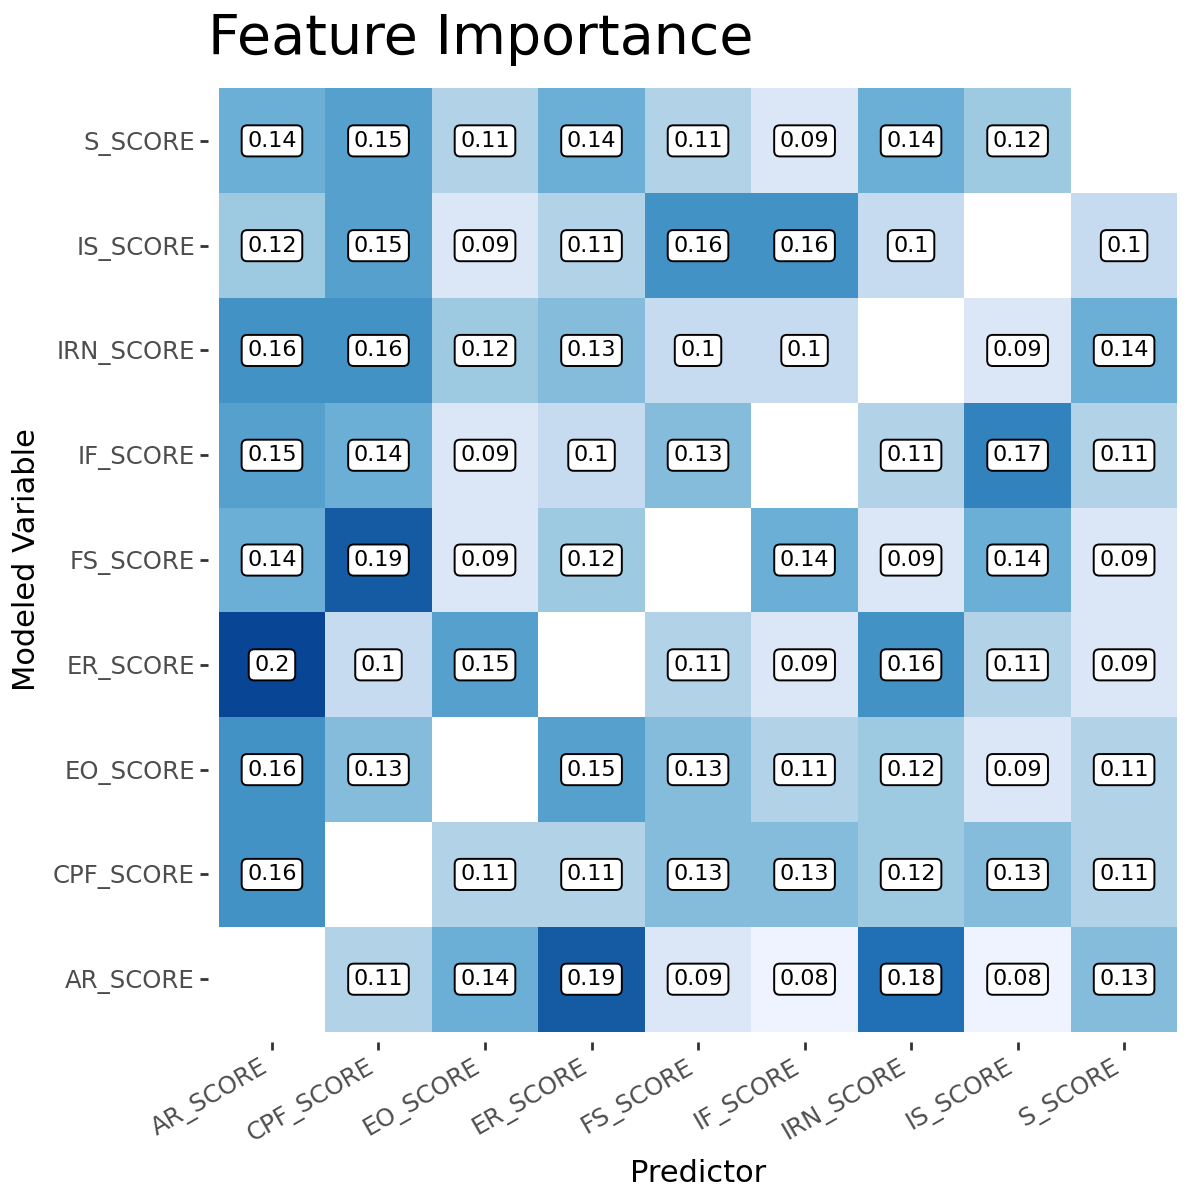

In [11]:
kernel.plot_feature_importance(dataset=0)

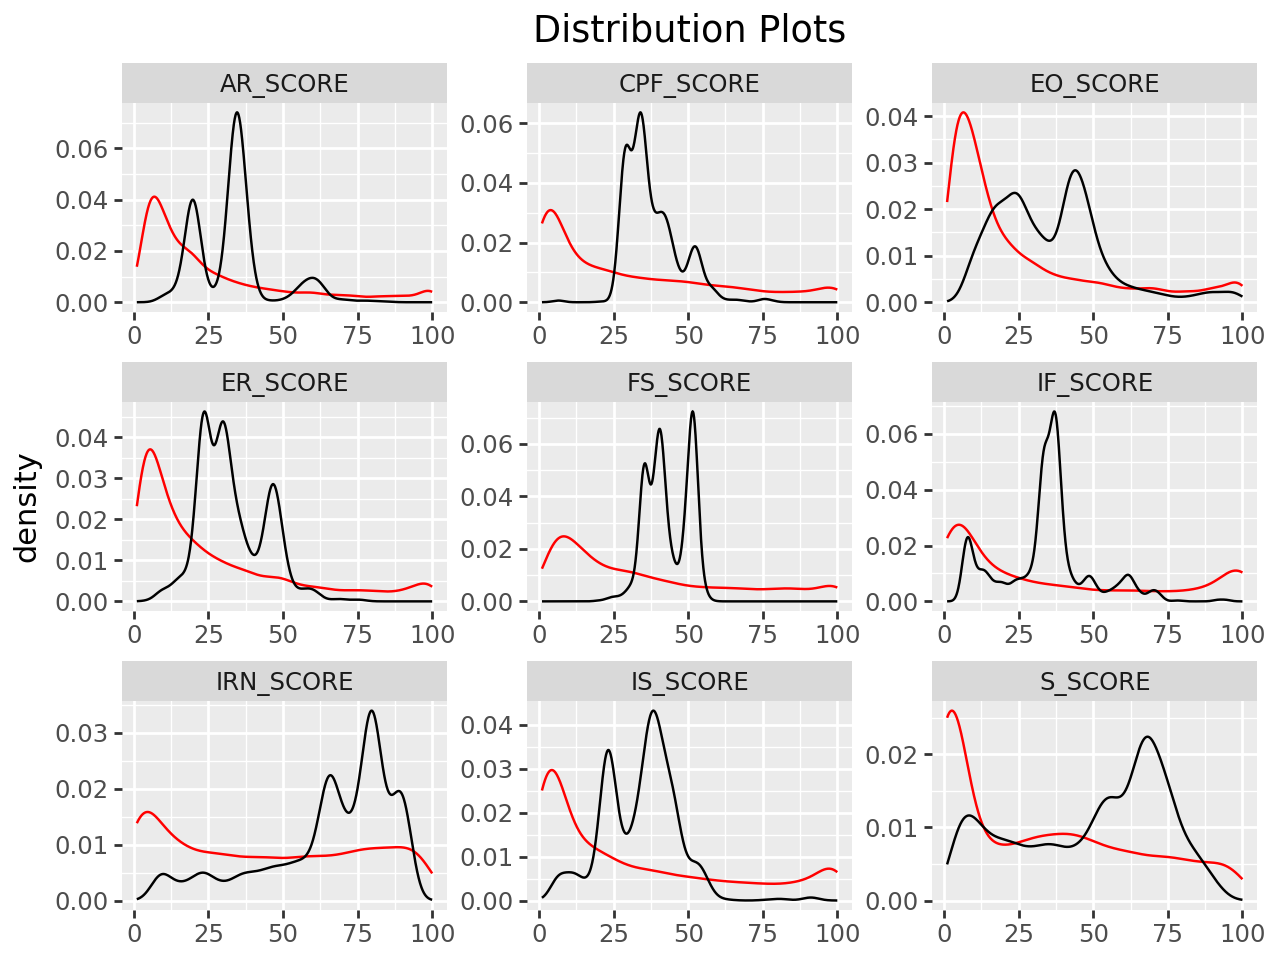

In [12]:
kernel.plot_imputed_distributions()

In [13]:
optimal_params = kernel.tune_parameters(
    dataset=0, 
    use_gbdt=True,
    num_iterations=500,
    random_state=1,
)
kernel.mice(1, variable_parameters=optimal_params)
# Show best hyperparameter for each feature
pd.DataFrame(optimal_params)

,S_SCORE,IRN_SCORE,EO_SCORE,IF_SCORE,AR_SCORE,ER_SCORE,IS_SCORE,CPF_SCORE,FS_SCORE
boosting,gbdt,gbdt,gbdt,gbdt,gbdt,gbdt,gbdt,gbdt,gbdt
data_sample_strategy,bagging,bagging,bagging,bagging,bagging,bagging,bagging,bagging,bagging
num_iterations,483,500,500,500,500,500,500,500,500
max_depth,5,4,4,5,3,4,5,5,5
num_leaves,23,17,11,18,18,15,6,16,15
min_data_in_leaf,2,8,1,1,100,10,123,19,4
min_sum_hessian_in_leaf,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
min_gain_to_split,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bagging_fraction,0.999136,0.501521,0.582307,0.779917,0.484219,0.989755,0.572203,0.537392,0.809136
feature_fraction_bynode,0.31248,0.299912,0.697415,0.778489,0.776686,0.621771,0.932327,0.643879,0.650828


C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



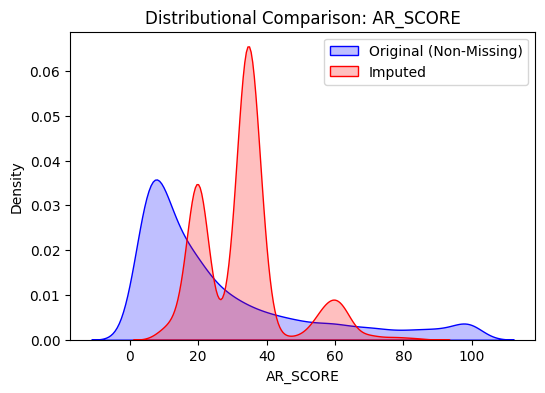

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



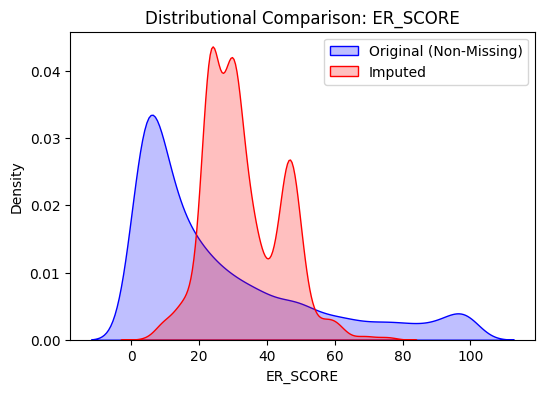

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



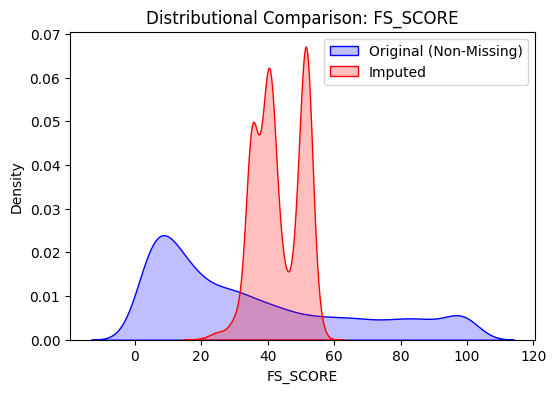

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



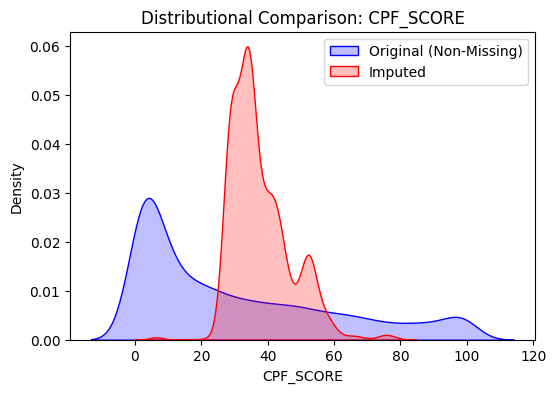

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



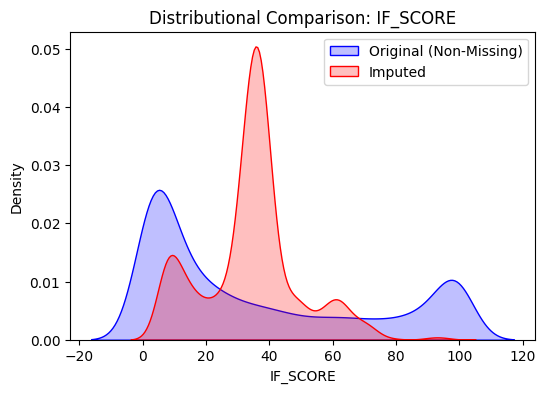

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



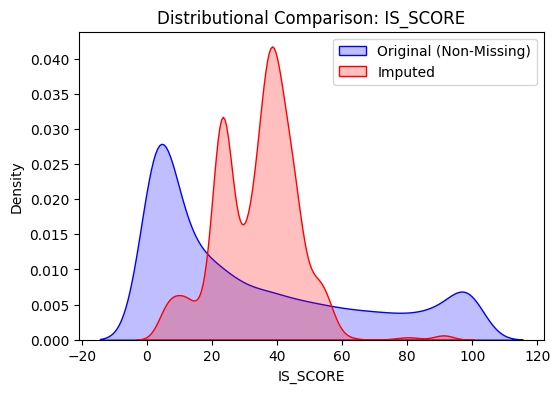

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



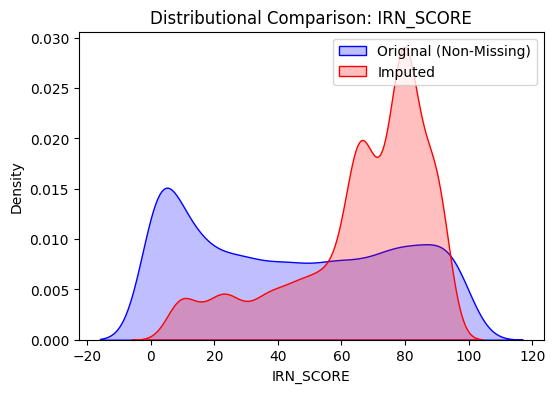

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



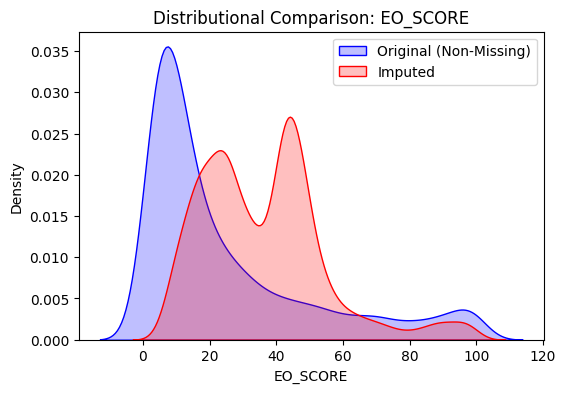

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

C:\Users\57176\AppData\Local\Temp\ipykernel_24028\432859349.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



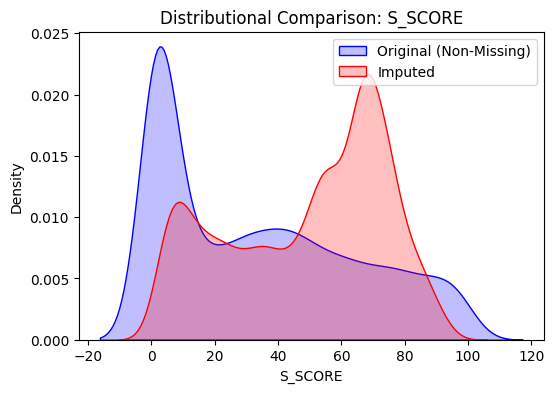

In [14]:
import seaborn as sns

original_data = pd.read_csv('datasets\cleaned_data_QS.csv', encoding='latin1')
score_columns = [col for col in df.columns if 'SCORE' in col]

original_data_clean = original_data.loc[:,score_columns]
imputed_data_clean = imputed_data.loc[:,score_columns]

def plot_distributions(original, imputed, column_name):
    plt.figure(figsize=(6, 4))

    sns.kdeplot(original.dropna(), label="Original (Non-Missing)", color='blue', shade=True)
    missing_indices = original[original.isna()].index
    sns.kdeplot(imputed.loc[missing_indices], label="Imputed", color='red', shade=True)
    
    plt.title(f'Distributional Comparison: {column_name}')
    plt.legend()
    plt.show()


for column in original_data_clean.columns:
    plot_distributions(original_data_clean[column], imputed_data_clean[column], column)

In [11]:
def randomly_delete_data(df, columns, missing_rate = 0.3, random_state = 2025):
    """
    Randomly setting specific columns data to NaN
    """
    df = df.copy()  # avoid to modify original data
    if random_state is not None:
        np.random.seed(random_state)
    
    for col in columns:
        if col in df.columns:
            mask = np.random.rand(len(df)) < missing_rate
            df.loc[mask, col] = np.nan 
    
    return df

columns_to_delete = ['IRN_SCORE', 'EO_SCORE','S_SCORE']
data_with_missing = randomly_delete_data(df, columns_to_delete, missing_rate=0.3, random_state=42)